In [1]:
import pandas as pd
from glob import glob
import json
import flatten_json as fj
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

import datetime
from time import strftime, gmtime


from sklearn.model_selection import TimeSeriesSplit


#Import prophet
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard

# Read in all the json files and normalize them in the wd
files = glob('*.json')

df = pd.DataFrame()

for f in files:
    print(f'file: {f}')

    with open(f, 'r', encoding='utf-8') as file:
        data = json.load(file)

    data = json.loads(json.dumps(data)) #.replace('[]', '[{}]'))

    #for i, d in enumerate(data['messages']):
    #    if not d['embeds']:
    #        data['messages'][i]['embeds'] = '[{}]'

    #messages = pd.json_normalize(data['messages'], max_level=1)

    dic = (fj.flatten(d) for d in data['messages'])
    messages = pd.DataFrame(dic)
    messages['file'] = f

    print(f'number of messages: {len(messages)}')

    df = pd.concat([df, messages], ignore_index=True)

df = df[df.columns.drop(list(df.filter(regex='reactions')))]
df = df[df.columns.drop(list(df.filter(regex='mentions')))]
df = df[df.columns.drop(list(df.filter(regex='reference')))]
df['file'].value_counts()

Importing plotly failed. Interactive plots will not work.
2023-02-01 20:24:15.673530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 20:24:16.293175: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/sebastian/mambaforge/envs/gpu-discord/lib/
2023-02-01 20:24:16.293299: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/sebastian/mamba

file: Fixitfixitfixit Drops & Tech - USA Nvidia Drops - 🟢us-rtx-4090 [990531075283492904].json
number of messages: 14134
file: Falcodrin Community Discord - 🇺🇸 Nvidia Alerts - 4090-us [1022693957571973170].json
number of messages: 2396
file: NerdSpeak - Tracking RTX - tracking-rtx-4090 [1024756126446792785].json
number of messages: 738


Fixitfixitfixit Drops & Tech - USA Nvidia Drops - 🟢us-rtx-4090 [990531075283492904].json    14134
Falcodrin Community Discord - 🇺🇸 Nvidia Alerts - 4090-us [1022693957571973170].json          2396
NerdSpeak - Tracking RTX - tracking-rtx-4090 [1024756126446792785].json                       738
Name: file, dtype: int64

In [2]:
# Check if tensorflow is using GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-02-01 20:24:18.475454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 20:24:18.690457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:18.694937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:18.694994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

True

In [3]:
#Split date and time from timestamp
df['Date'] = df['timestamp'].str.split('T').str[0]
df['Time'] = df['timestamp'].str.split('T').str[1].str.split('.').str[0]

#get weekday
df['Day'] = pd.to_datetime(df['timestamp']).dt.day_name()

#convert time to seconds
df['Seconds'] = pd.to_datetime(df['timestamp']).dt.hour*3600 + pd.to_datetime(df['timestamp']).dt.minute*60 + pd.to_datetime(df['timestamp']).dt.second

In [4]:
search_cols = ['embeds_0_title', 'embeds_0_url','embeds_0_description']

# Create boolean column if 'bestbuy' is found in any of the above columns:
df['BestBuy'] = df[search_cols].apply(lambda x: x.astype(str).str.contains('bestbuy', case=False, na=False)).any(axis=1)

df['FE'] = df[search_cols].apply(lambda x: x.astype(str).str.contains('FE|founder|Founder', case=True, na=False)).any(axis=1)

In [5]:
df.to_csv('gpu-discord.csv', index=False)

In [6]:
#Filter df if BestBuy is True
df = df[df['BestBuy'] == True]

In [7]:
# Get the Dates from df and create new BestBuy and FE columns on whether or not there was any True value for that day
df_dates_summary = df.groupby(['Date']).agg({'BestBuy': 'any', 'FE': 'any'}).reset_index()

#Filter on FE
#df = df[df['FE'] == True]

df.shape
# Get the total number of best buy trues using sum
prob_of_FE = df_dates_summary['FE'].sum()/df_dates_summary['BestBuy'].sum()
prob_of_FE

0.1864406779661017

In [8]:
# Get last date where FE is True, should be 12/30
df_dates_summary[df_dates_summary['FE'] == True]['Date']

2     2022-10-19
24    2022-12-01
26    2022-12-20
27    2022-12-21
28    2022-12-22
29    2022-12-23
32    2022-12-26
33    2022-12-27
34    2022-12-28
35    2022-12-29
36    2022-12-30
Name: Date, dtype: object

In [9]:
df_dates_summary.head()

,Date,BestBuy,FE
0,2022-10-10,True,False
1,2022-10-12,True,False
2,2022-10-19,True,True
3,2022-10-22,True,False
4,2022-10-23,True,False


In [10]:
df['embeds_0_title'].value_counts()

In Stock - ASUS RTX 4090 TUF                                                                        195
GIGABYTE GeForce RTX 4090 GAMING OC                                                                  97
In Stock - GIGABYTE RTX 4090 WINDFORCE                                                               85
In Stock - Nvidia Founders Edition RTX 4090 Graphics Card                                            82
NVIDIA GeForce RTX 4090                                                                              69
GIGABYTE GeForce RTX 4090 WINDFORCE                                                                  61
ASUS GeForce RTX 4090 TUF GAMING                                                                     49
MSI GeForce RTX 4090 GAMING TRIO                                                                     47
In Stock - MSI RTX 4090 GAMING TRIO 24G                                                              46
In Stock - GIGABYTE RTX 4090 24GB WINDFORCE Black               

In [11]:
#custom order of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [12]:

# Define a custom formatter function to convert seconds to time format
def time_formatter(x, y=0):
    return strftime('%I:%M %p', gmtime(x))

In [13]:
# Find the mean seconds for each day and convert back to time format
mean_time_secs = df.groupby('Day')['Seconds'].mean()
mean_time = mean_time_secs.apply(lambda x: time_formatter(x))

# Find the median seconds for each day and convert back to time format
median_time_secs = df.groupby('Day')['Seconds'].median()
median_time = median_time_secs.apply(lambda x: time_formatter(x))

#Find the standard deviation of seconds for each day and convert back to time format
std_time_secs = df.groupby('Day')['Seconds'].std()

time_df = pd.DataFrame({'Mean (Secs)': mean_time_secs
                        , 'Mean': mean_time
                        , 'Median (Secs)': median_time_secs
                        , 'Median': median_time
                        , 'Std': std_time_secs}
                        , index=days)

display(time_df)

,Mean (Secs),Mean,Median (Secs),Median,Std
Monday,58703.131579,04:18 PM,64347.0,05:52 PM,22602.449748
Tuesday,66454.015873,06:27 PM,68151.0,06:55 PM,12242.512131
Wednesday,52472.217910,02:34 PM,55330.0,03:22 PM,18554.750115
Thursday,52447.445455,02:34 PM,59319.5,04:28 PM,21386.827050
Friday,38685.861538,10:44 AM,38414.0,10:40 AM,24669.161190


In [14]:
# Liklihood of notify on a certain day
day_dist = df['Day'].value_counts(normalize=True)
day_dist = day_dist.reindex(days)

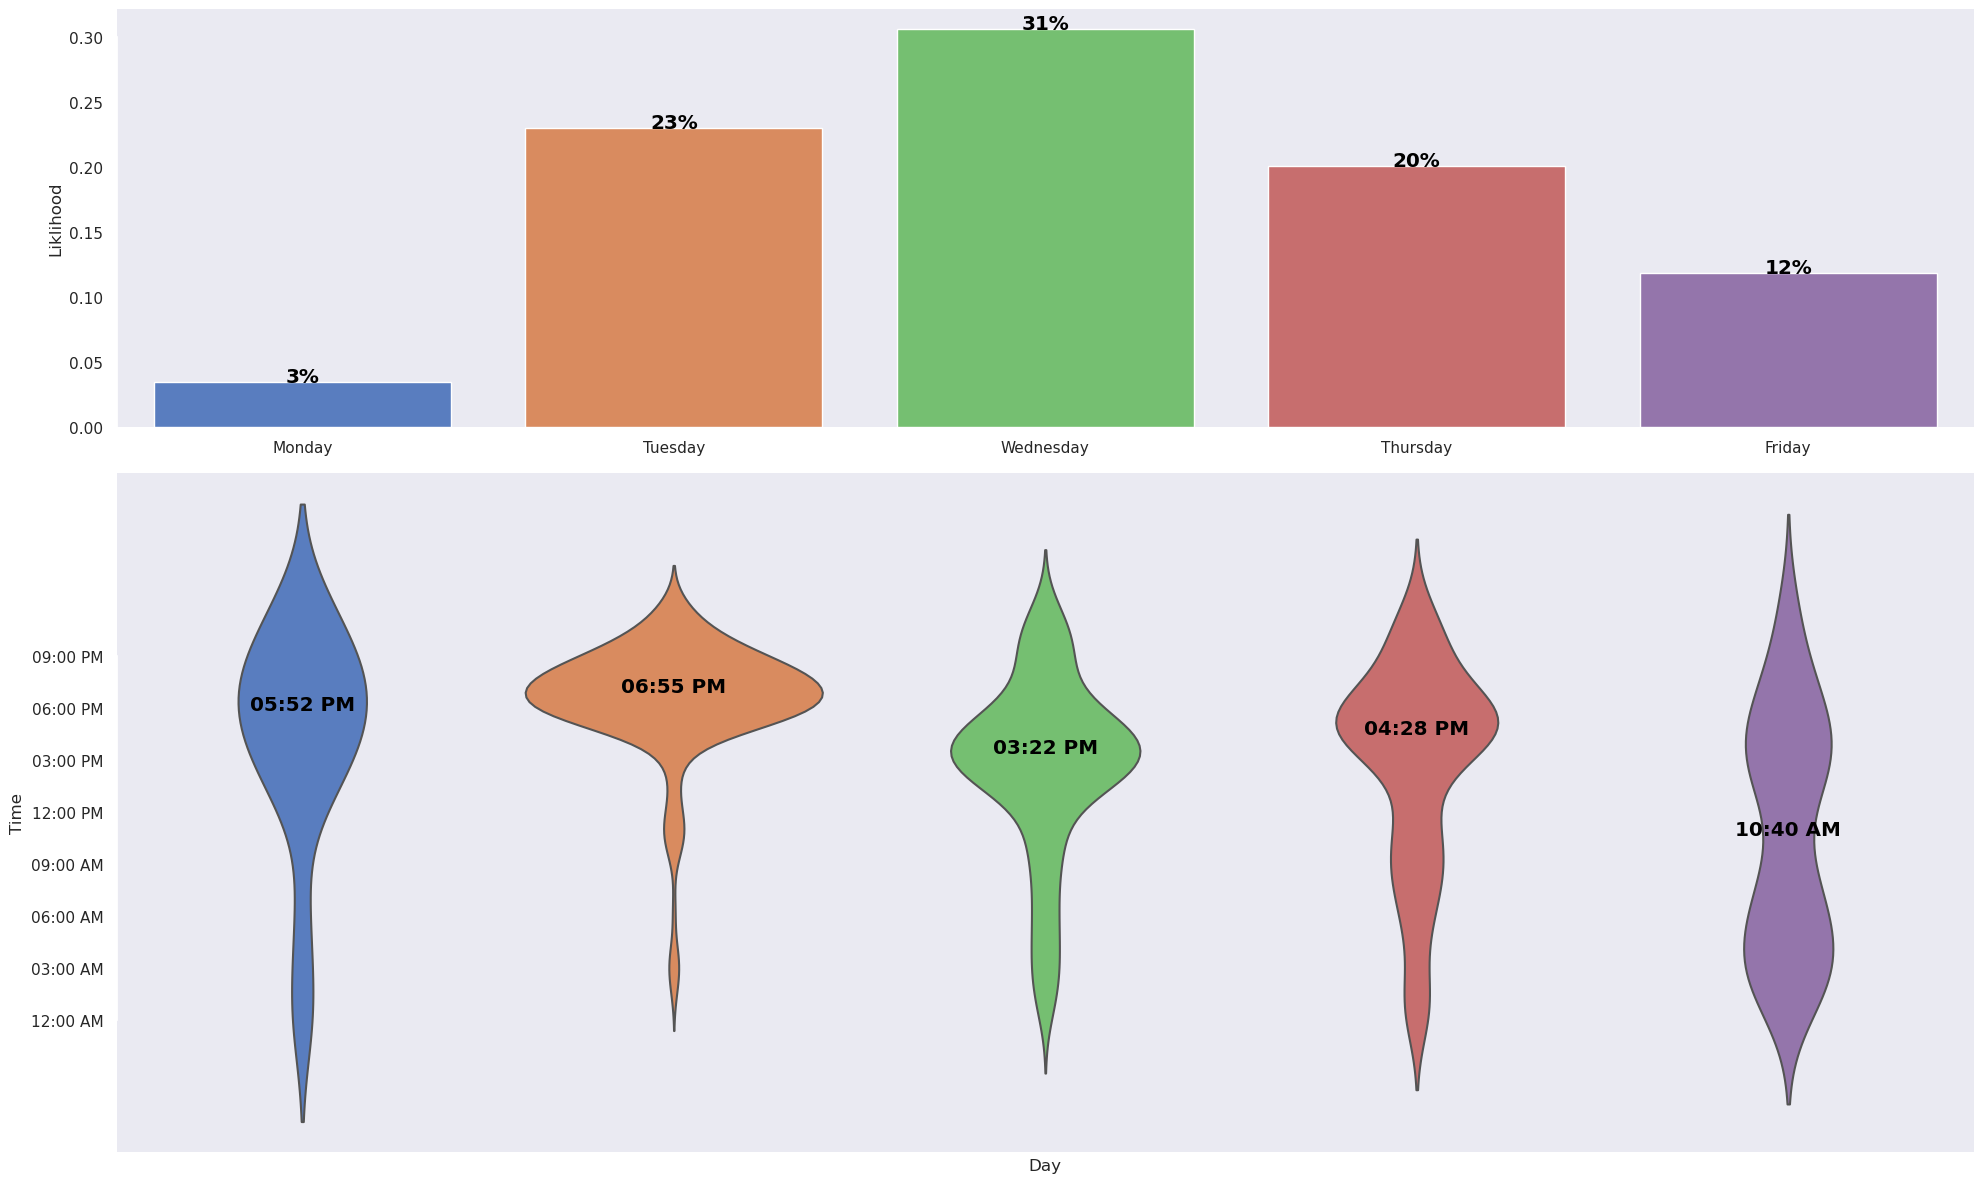

In [15]:


# Set the theme
sns.set_theme(style="dark",
palette = "muted"
)

# Create a figure with two subplots
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 3.25]})

# Plot the boxplot on the first subplot
sns.violinplot(x='Day', y='Seconds', data=df, order=days, ax=ax1, inner=None
    #showcaps=False,
    #flierprops={"marker": "o"},
    #medianprops={"color": "w"},
    )

# Set the Y-axis tick labels to the time format using the custom formatter
ax1.yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Plot the day distribution as a barplot on the second subplot
sns.barplot(x=days, y=day_dist, ax=ax2, palette="muted")

ax2.set_ylabel('Liklihood')
#ax2.set_ylim(0, 1)

# Set the Y-axis label of the first subplot
ax1.set_ylabel('Time')

# Set the yticks 
ax1.set_yticks(np.arange(0, 86400, 10800))

#remove borders on subplots
sns.despine(bottom=True, trim=True)

##show mean and median times on the boxplot
for i, day in enumerate(days):
    ax1.text(i, median_time_secs[day], f'{median_time[day]}', horizontalalignment='center', size='large', weight='semibold', color = "Black")

#show lilklihood of notify on the barplot
for i, day in enumerate(days):
    ax2.text(i, day_dist[day], f'{day_dist[day]:.0%}', horizontalalignment='center', size='large', weight='semibold', color = "Black")
    
#Make the subplots share the same x-axis
plt.setp(ax1.get_xticklabels(), visible=False)

fig.tight_layout()
plt.show()


Text(0.5, 0.98, '4090 Times for each day')

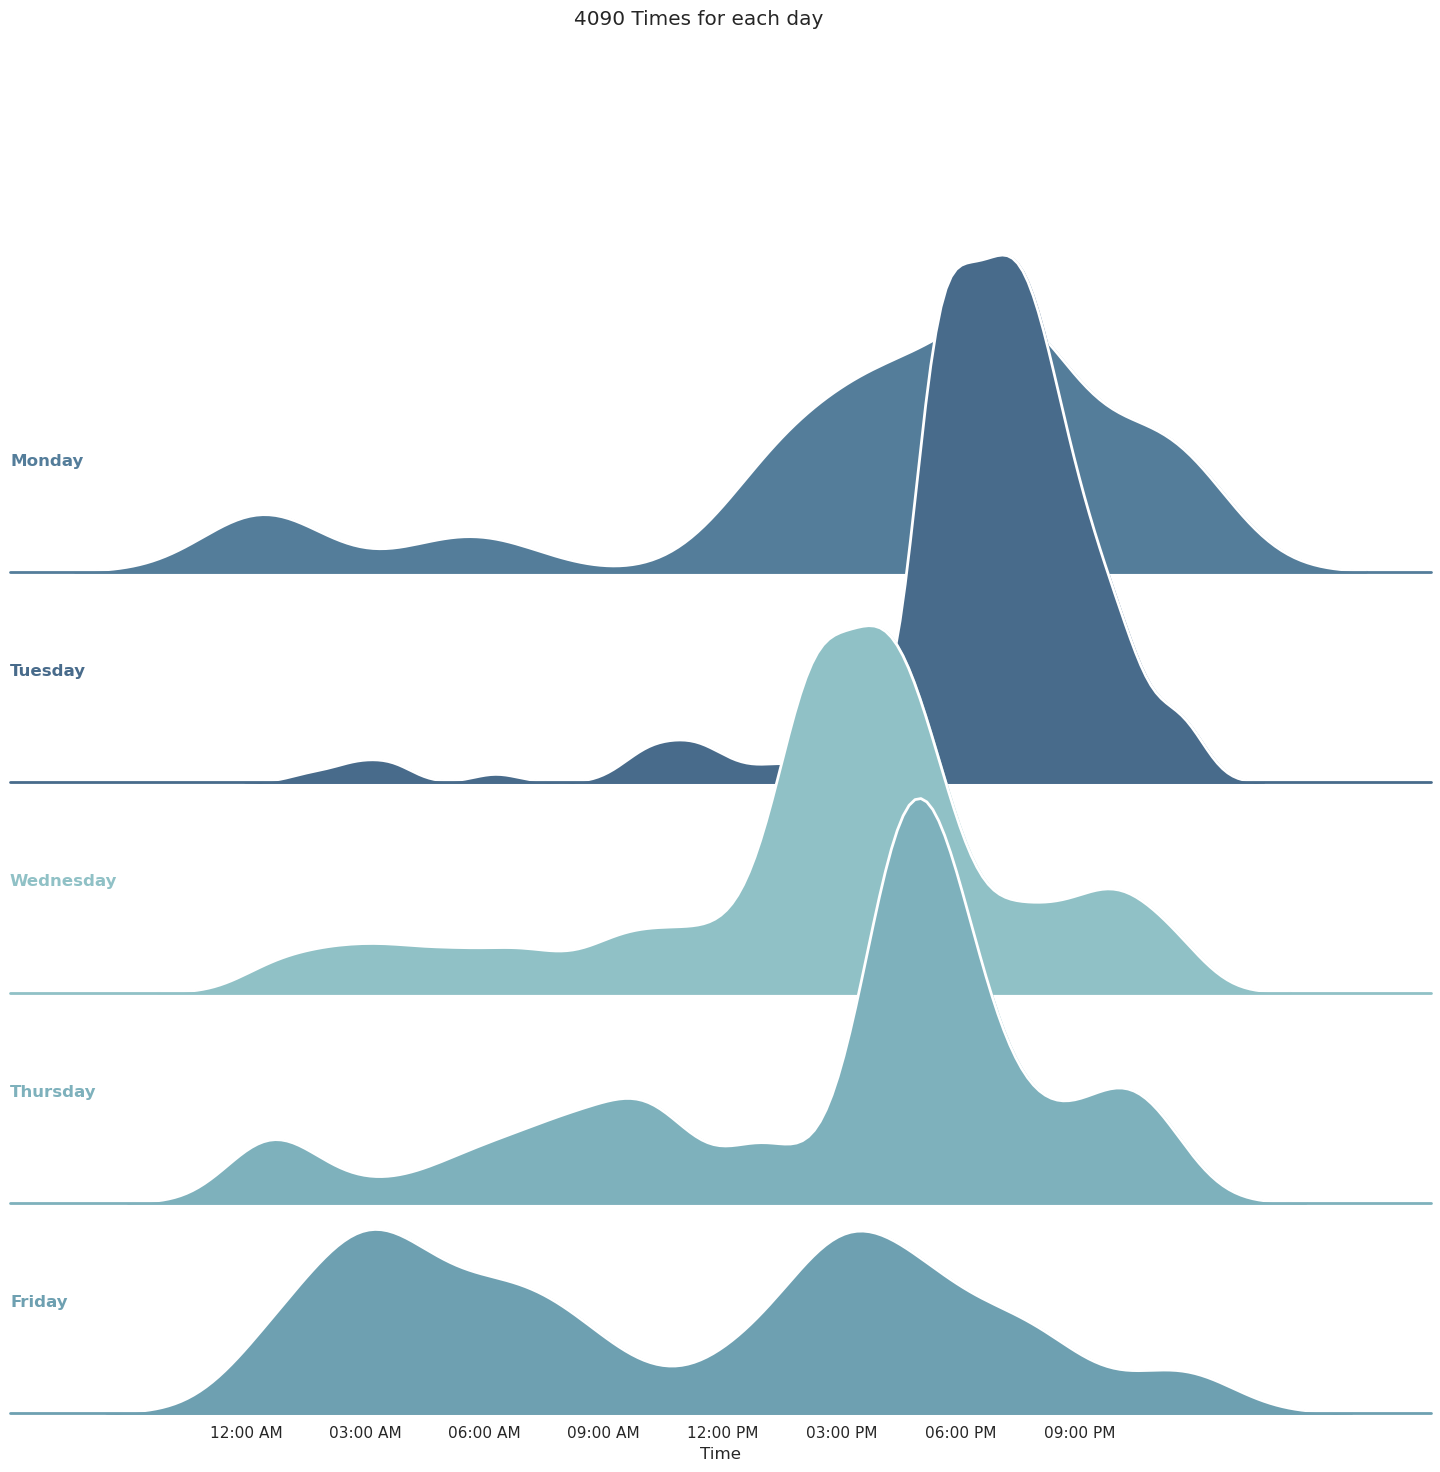

In [16]:


sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Day", hue="Day", aspect=5, height=3, palette=pal, row_order=days)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Seconds",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Seconds", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
# Set the Y-axis tick labels to the time format using the custom formatter
    ax.xaxis.set_major_formatter(FuncFormatter(time_formatter))
# Set X axis bounds
    #ax.set_xlim(0, 86400)

g.map(label, "Time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.62)

#set the xticks
g.set(xticks=np.arange(0, 86400, 10800))


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#Set final title
g.fig.suptitle('4090 Times for each day')


In [17]:
dfd = df_dates_summary.copy()

#min date from drop
min_date = pd.to_datetime(dfd['Date'].min())

#max date from drop
#max_date = drops.max()
# set max date to today
max_date = pd.to_datetime('today')

# Convert BestBuy and FE to floats
dfd['BestBuy'] = dfd['BestBuy'].astype(float)
dfd['FE'] = dfd['FE'].astype(float)
dfd['Date'] = pd.to_datetime(dfd['Date'])

#create df with all dates between min and max date +- 7 days
dates = pd.date_range(min_date - pd.Timedelta(days=7), max_date)

# Combine dates with the data from dfd.
# Create a new BestBuy and FE column and fill with the values from dfd if if exists, otherwise fill with 0
dfd = dates.to_frame(name='Date').merge(dfd, how='left', on='Date').fillna(0)



# create a column called Drop with 1's if FE is true, "prob_of_FE" if FE is false BestBuy is true, and 0 if both are false or date doesn't exist
dfd['Drop'] = np.where(dfd['FE'] == 1, 1, np.where(dfd['BestBuy'] == 1, prob_of_FE, 0))


In [18]:
dfd['Drop'].value_counts()

# Keep only Date and Drop column
dfd = dfd[['Date', 'Drop']]


In [19]:
#calculate the differences between every date where drop = 1
(dfd[dfd['Drop'] == 1]['Date'].diff().dt.days).mean()

#7 days (every week)

7.2

In [20]:
# Prepare the data

start_date = dfd['Date'].min()

dfd['Date'] = pd.to_datetime(dfd['Date'])
dfd['days'] = (dfd['Date'] - start_date).dt.days

dfd = dfd.sort_values(by='Date')
X = dfd[['days']].values
y = dfd['Drop'].values


2023-02-01 20:24:32.248770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:32.249237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:32.249442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:32.252306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 20:24:32.252401: I tensorflow/compile

Epoch 1/500


2023-02-01 20:24:39.272519: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4a9c003d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 20:24:39.272561: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-02-01 20:24:39.322787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-01 20:24:39.764045: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 20:24:39.875479: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 8s 8s/step - loss: 13.4127 - accuracy: 0.2727 - val_loss: 13.1366 - val_accuracy: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 97ms/step - loss: 13.1751 - accuracy: 0.4545 - val_loss: 12.9001 - val_accuracy: 0.0500
Epoch 3/500
1/1 [==============================] - 0s 97ms/step - loss: 12.9389 - accuracy: 0.7273 - val_loss: 12.6670 - val_accuracy: 0.5500
Epoch 4/500
1/1 [==============================] - 0s 104ms/step - loss: 12.7074 - accuracy: 0.7727 - val_loss: 12.4381 - val_accuracy: 0.5500
Epoch 5/500
1/1 [==============================] - 0s 91ms/step - loss: 12.4790 - accuracy: 0.7727 - val_loss: 12.2123 - val_accuracy: 0.5500
Epoch 6/500
1/1 [==============================] - 0s 100ms/step - loss: 12.2541 - accuracy: 0.7727 - val_loss: 11.9894 - val_accuracy: 0.5500
Epoch 7/500
1/1 [==============================] - 0s 98ms/step - loss: 12.0321 - accuracy: 0.7727 - val_loss: 11.7699 - val_accuracy: 0.5500
Epoch 8/500
1/

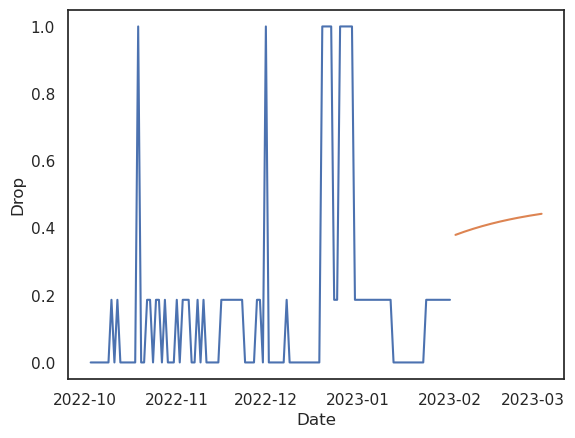

In [25]:

# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs')

n_inputs = 1

# Add L1 and L2 regularization
reg = L1L2(l1=0.01, l2=0.01)

# Define the model
model = Sequential()
# Add LSTM layers with dropout and kernel regularization
model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, recurrent_regularizer=reg, input_shape=(n_inputs, 1)))
model.add(Reshape((-1, 32)))
model.add(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, recurrent_regularizer=reg))
model.add(Reshape((-1, 16)))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2, recurrent_regularizer=reg))
# Add a dense output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Define the time series cross validation object
tscv = TimeSeriesSplit(n_splits=5)

# Train the model using cross validation
for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
    X_val = np.reshape(X_val, (X_val.shape[0], 1, 1))
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=64, callbacks=[tensorboard_callback])


# Create a range of future dates
future_dates = pd.date_range(start=max_date + pd.Timedelta(days=1), periods=30)

# Create a new dataframe for future dates
future_df = pd.DataFrame({'days' : (future_dates - start_date).days})

# Use the model to make predictions for future dates
future_predictions = model.predict(future_df)

# Add the predictions to the future dataframe


future_df['Predicted Drop'] = np.squeeze(future_predictions)
future_df['Date'] = future_dates

result_df = pd.concat([dfd, future_df], ignore_index=True)

# Plot the historical and future drops
plt.plot(result_df['Date'], result_df['Drop'])
plt.plot(result_df['Date'], result_df['Predicted Drop'])
plt.xlabel('Date')
plt.ylabel('Drop')
plt.show()

In [22]:
# Use prophet to predict future drops
# Create a new dataframe with only the Date and Drop columns
prophet_df = dfd[['Date', 'Drop']]
prophet_df.head()

,Date,Drop
0,2022-10-03,0.0
1,2022-10-04,0.0
2,2022-10-05,0.0
3,2022-10-06,0.0
4,2022-10-07,0.0


20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing


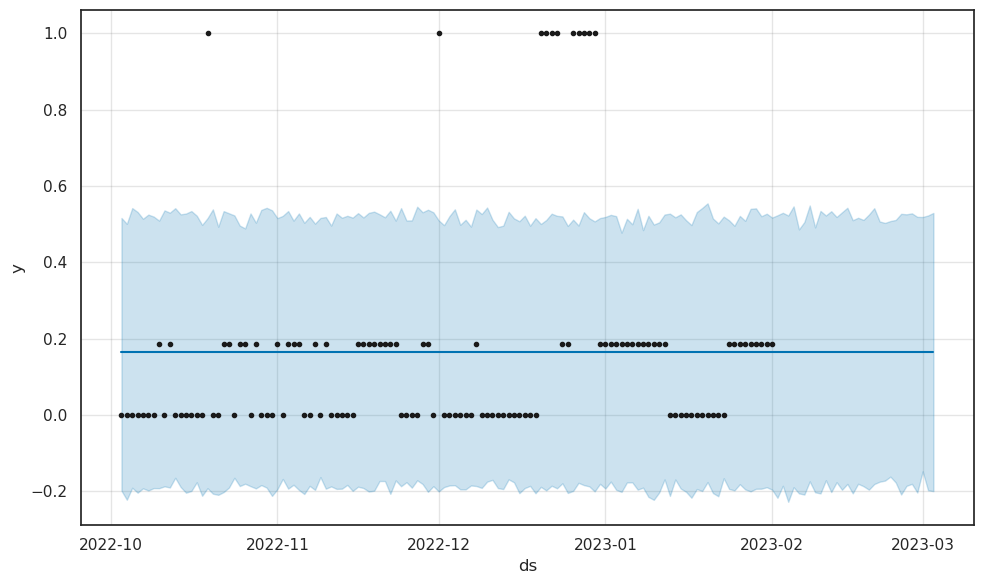

In [23]:
# Rename the columns to ds and y
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Drop': 'y'})

# Create the model
m = Prophet(growth = 'flat', daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)

# Fit the model
m.fit(prophet_df)

# Create a dataframe with future dates
future = m.make_future_dataframe(periods=30)

# Make predictions
forecast = m.predict(future)

# Plot the predictions
m.plot(forecast)
plt.show()



In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Now use an arima model to predict future drops
# Create a new dataframe with only the Date and Drop columns
arima_df = dfd[['Date', 'Drop']]
arima_df.head()

# Rename the columns to ds and y
arima_df = arima_df.rename(columns={'Date': 'ds', 'Drop': 'y'})

# Create the model
arima_model = ARIMA(arima_df['ds'], order=(1, 1, 1))

# Fit the model
arima_model_fit = arima_model.fit()

# Make predictions for dates after the last date in the dataset
arima_predictions = arima_model_fit.predict(start=len(arima_df), end=len(arima_df) + 30)

# Add the predictions to the dataframe
arima_df['Predicted Drop'] = arima_predictions

# Plot the predictions with predictions as a different color with seaborn
sns.lineplot(data=arima_df, x='ds', y='y')
sns.lineplot(data=arima_df, x='ds', y='Predicted Drop')
plt.show()



UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<m8[ns]') and dtype('O')

In [ ]:
arima_df.y.value_counts()
